In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot


**Which series are you watching? 
<br>I’m kidding, if you need help, please ask :) 
<br>https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ 
<br>That’s the rolling arima 
<br>And remember, you need some part to pre train the model, one part to calculate the base of a MSE/MAE, and then your rolling ARIMA really starts**

### 1.Start simple, explore the target



In [16]:
df = pd.read_csv('Detections_2020.csv')
df.head(40)

,day,month,target,organizations,malwares,users
0,15,1,7532,251,3144,3591
1,16,1,7774,257,3146,3680
2,17,1,7325,258,2971,3446
3,18,1,6501,225,2610,2458
4,19,1,6361,219,2741,2503
5,20,1,7956,268,2535,3800
6,21,1,9159,274,3117,4228
7,22,1,9777,285,3576,4597
8,23,1,9592,294,3425,4288
9,24,1,8550,275,3142,3682


Let's look on some summary statistics

In [18]:
df['target'].describe()

count      159.000000
mean     17461.452830
std      11806.349353
min         40.000000
25%       9847.500000
50%      13742.000000
75%      21329.500000
max      62207.000000
Name: target, dtype: float64

In [19]:
df.describe()

,day,month,target,organizations,malwares,users
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,15.779874,3.591195,17461.452830,456.270440,3454.867925,6288.144654
std,8.611626,1.575982,11806.349353,146.825768,1117.073534,2438.426588
min,1.000000,1.000000,40.000000,21.000000,34.000000,23.000000
25%,8.500000,2.000000,9847.500000,336.000000,2750.000000,4635.500000
50%,16.000000,4.000000,13742.000000,445.000000,3219.000000,6046.000000
75%,23.000000,5.000000,21329.500000,583.500000,4362.500000,7930.000000
max,31.000000,6.000000,62207.000000,716.000000,5876.000000,12125.000000


### 2.Look for trend and seasonality


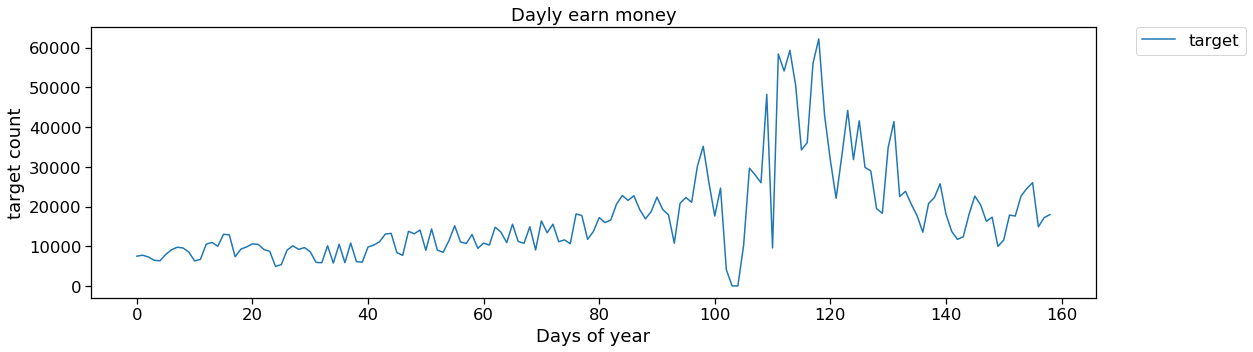

In [20]:
fig = plt.figure(figsize = (18,5))
plt.plot(df.target, label='target')

plt.title('Dayly earn money')
plt.xlabel("Days of year")
plt.ylabel("target count")
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.);

We can see that the  dataset data has't a clear trend, but has an anomaly values in interval `days_of_the_period[100:140]`

Also we doesn't see a seasonality here, but let us check it with the `Dickey-Fuller test`

In [29]:
class StationarityTests:
    '''class which implements the ADF test from the statsmodels python package'''
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], 
                                  index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)
            
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df.target, printResults = True)
print(f"Is the time series stationary? {sTest.isStationary}")

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.045040
P-Value                   0.267180
# Lags Used               4.000000
# Observations Used     154.000000
Critical Value (1%)      -3.473543
Critical Value (5%)      -2.880498
Critical Value (10%)     -2.576878
dtype: float64
Is the time series stationary? False


Our series is not stationary

As you would expect, the results show that the series is actually stationary. In this case, the P-Value from our ADF test is bigger than our 5% significance level, therefore we can't reject the Null hypothesis and not  accept the alternate hypothesis that stationarity exists.
Taking a look at the critical value yields the same conclusion. The tests critical value ends up being -2.045040 which is bigger the 5% critical value of -2.880498 and so we have enough evidence to conclude that unit root  exist. In other words, the series is not stationary.

Let’s also take a quick look at an autocorrelation plot of the time series. This is also built-in to Pandas. The example below plots the autocorrelation for a large number of lags in the time series.

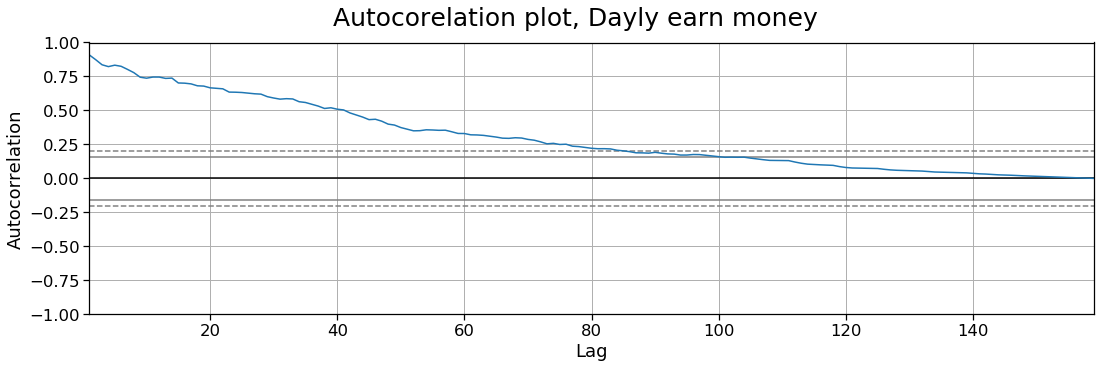

In [36]:
fig = plt.figure(figsize = (18,5))
fig.suptitle('Autocorelation plot, Dayly earn money', fontsize=25)

autocorrelation_plot(df);

Running the example, we can see that there is a positive correlation for the whole period that is perhaps significant for the first 60-65 lags.

A good starting point for the AR parameter of the model may be 40.


### 3.Look for potential anomalies



### 4.Find a metric for the expected error



### 5.Build an ARIMA model that fit this target



### 6.Make a rolling ARIMA and see it’s behaviour



## EXTRA: 
### 7.See how the other variables influence the target and build a meta regressor or clasifier involving more variables